In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import torchvision.models as models
from  torch.utils.data import random_split
from sklearn.metrics import r2_score

<p>NOTE: I made a slight modification to the competition dataset where I wrapped the `train_images` folder in another folder called `Train`, and likewise for the `test_images` folder, which is wrapped in a folder called `Test`. This dataset I used is included as a .zip in my submission. The reason I made this slight modification is because I used Pytorch's ImageFolder method, which requires such a directory structure.</p>

<h2>Define constants and helper functions</h2>

In [2]:
ROOT_DIR="/kaggle/input/barrys-cs480-dataset"
BATCH_SIZE = 76
OUTPUT_TRAIT_NAMES = [
    'X4_mean',
    'X11_mean',
    'X18_mean',
    'X26_mean',
    'X50_mean',
    'X3112_mean'
]

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using cuda")
elif torch.backends.mps.is_available():
    # device = torch.device("mps")
    device = torch.device("cpu")
    print("using mps")
else:
    device = torch.device("cpu")
    print("cpu")

using cuda


In [4]:
def loadCsvData(csv_file):
    return pd.read_csv(ROOT_DIR + f"/data/{csv_file}", header=0)

In [5]:
def normalizeTraits(df, mean, std):
    return (df - mean) / std

def unnormalize(norm_df, mean, std):
    return std * norm_df + mean

In [6]:
def getTraitsAsTensors(csv_vals, columns, doNorm=True):
    traits = csv_vals[columns]
    traits_mean = traits.mean()
    traits_std = traits.std()
    if doNorm:
        traits = normalizeTraits(traits, traits_mean, traits_std)
    tensors = [torch.tensor(row, dtype=torch.float32) for row in traits.values]
    return tensors, traits_mean, traits_std

In [7]:
import re

def getImageId(filename):
    match = re.search('.*\/.*_images\/(?P<id>[0-9]+)\.jpeg', filename)
    return match.groupdict()["id"]

<h2>Visualize output traits</h2>

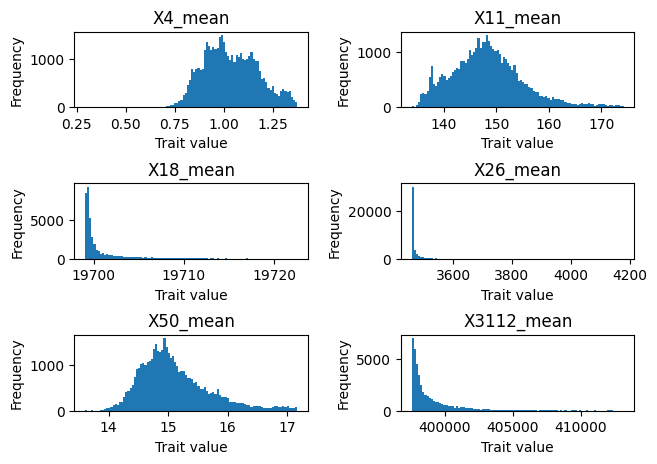

In [8]:
train_csv_for_hist = loadCsvData("train.csv")
X4_mean_vals = train_csv_for_hist["X4_mean"]
X11_mean_vals = train_csv_for_hist["X11_mean"]
X18_mean_vals = train_csv_for_hist["X18_mean"]
X26_mean_vals = train_csv_for_hist["X26_mean"]
X50_mean_vals = train_csv_for_hist["X50_mean"]
X3112_mean_vals = train_csv_for_hist["X3112_mean"]

fig, axs = plt.subplots(3, 2)
NUM_BINS = 100
axs[0, 0].hist(X4_mean_vals, NUM_BINS)
axs[0, 0].set_title('X4_mean')
axs[0, 1].hist(X11_mean_vals, NUM_BINS)
axs[0, 1].set_title('X11_mean')
axs[1, 0].hist(X18_mean_vals, NUM_BINS)
axs[1, 0].set_title('X18_mean')
axs[1, 1].hist(X26_mean_vals, NUM_BINS)
axs[1, 1].set_title('X26_mean')
axs[2, 0].hist(X50_mean_vals, NUM_BINS)
axs[2, 0].set_title('X50_mean')
axs[2, 1].hist(X3112_mean_vals, NUM_BINS)
axs[2, 1].set_title('X3112_mean')

for ax in axs.flat:
    ax.set(xlabel='Trait value', ylabel='Frequency')

plt.subplots_adjust(right=1, top = 0.8, bottom=0.01, hspace=1, wspace=0.4)

<h2>Define custom Dataset class and create training and validation sets<h2>

In [9]:
class PlantsDataSet:
    def __init__(self, root_dir, train=True, transform=None):
        if (train):
            csv_file = "train.csv"
            image_folder = "Train"
        else:
            csv_file = "test.csv"
            image_folder = "Test"

        self.imgs = datasets.ImageFolder(root_dir + f"/data/{image_folder}", transform=transform)
        idToImgIndex = dict()
        self.num_imgs = len(self.imgs)
        for i in range(self.num_imgs):
            filename = self.imgs.imgs[i][0]
            id = getImageId(filename)
            idToImgIndex[id] = i
        
        csv_vals = loadCsvData(csv_file)
        self.ids = csv_vals.id
        self.imgIndicesInOrder = [idToImgIndex[str(idNumber)] for idNumber in self.ids]

        COLUMN_NAMES = list(csv_vals.columns)
        ALL_INPUT_TRAITS = COLUMN_NAMES[1:-6] if train else COLUMN_NAMES[1:]
        INPUT_TRAIT_NAMES = ALL_INPUT_TRAITS
        self.norm_input_traits, self.input_traits_mean, self.input_traits_std = getTraitsAsTensors(csv_vals, INPUT_TRAIT_NAMES, doNorm=True)
        self.train = True if train else False
        if (train):
            self.output_traits, _, _ = getTraitsAsTensors(csv_vals, OUTPUT_TRAIT_NAMES, doNorm=False)
            self.norm_output_traits, self.output_traits_mean, self.output_traits_std = getTraitsAsTensors(csv_vals, OUTPUT_TRAIT_NAMES, doNorm=True)
    def __len__(self):
        return self.num_imgs
    
    def __getitem__(self, idx):
        id = self.ids[idx]
        imgIndex = self.imgIndicesInOrder[idx]
        if self.train:
            sample = {'image': self.imgs[imgIndex], 
                      'norm_input_traits': self.norm_input_traits[idx],
                      'norm_output_traits': self.norm_output_traits[idx],
                      'output_traits': self.output_traits[idx],
                      'id': id}
            
        else:
            sample = {'image': self.imgs[imgIndex], 
                      'norm_input_traits': self.norm_input_traits[idx],
                      'id': id}
        return sample   

In [10]:
preprocess = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [11]:
labeled_dataset = PlantsDataSet(root_dir=ROOT_DIR, train=True, transform=preprocess)
train_dataset, val_dataset = random_split(labeled_dataset, [0.8, 0.2])
train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
test_dataset = PlantsDataSet(root_dir=ROOT_DIR, train=False, transform=preprocess)
test_dataloader =  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

<h2>Define neural network model<h2>

In [19]:
class StackedNN(nn.Module):
    def __init__(self):
        super(StackedNN, self).__init__()
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        self.cnn = resnet
        self.imageBranch = nn.Sequential(
            self.cnn,
            nn.Linear(1000, 512),
            nn.LayerNorm(512, 512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(512, 4)
        )
        self.ancillaryBranch = nn.Sequential(
            nn.Linear(163, 64),
            nn.LayerNorm(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        self.concatenatedBranch = nn.Sequential(
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 6)
        )


    def forward(self, img, ancillary):
        imageBranchOutput = self.imageBranch(img)
        ancillaryBranchOutput = self.ancillaryBranch(ancillary)

        concatenated = torch.cat([imageBranchOutput, ancillaryBranchOutput], dim=1)
        output = self.concatenatedBranch(concatenated)

        return output

In [20]:
def train(myNet, num_epochs, train_dataloader, learning_rate=0.001):
    print(f"Beginning training for model using {num_epochs} epochs")
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(myNet.parameters(), lr=learning_rate)
    batch_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, sample_batch in enumerate(train_dataloader, 0):
            image_batch = sample_batch["image"][0].to(device)
            ancillary_batch = sample_batch["norm_input_traits"].to(device)
            targets_batch = sample_batch["norm_output_traits"].to(device)
            prediction = myNet(image_batch, ancillary_batch)

            optimizer.zero_grad()
            loss = criterion(prediction, targets_batch)
            loss.backward()

            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            # print(i)
            if (i + 1) % 50 == 0:    # Print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:4d}] loss: {running_loss / BATCH_SIZE:.3f}')
                batch_losses.append(running_loss / BATCH_SIZE)
                running_loss = 0

    print(f'Finished Training for model using {num_epochs} epochs')
    return batch_losses

<h2>Train models using different number of epochs</h2>

In [21]:
# 3 epochs
myNet3 = StackedNN().to(device)
batch_losses3 = train(myNet3, 3, train_dataloader)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s] 


Beginning training for model using 3 epochs


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1,   50] loss: 0.699
[1,  100] loss: 0.632
[1,  150] loss: 0.604
[1,  200] loss: 0.624
[1,  250] loss: 0.598
[1,  300] loss: 0.617
[1,  350] loss: 0.587
[1,  400] loss: 0.605
[1,  450] loss: 0.592
[2,   50] loss: 0.581
[2,  100] loss: 0.586
[2,  150] loss: 0.580
[2,  200] loss: 0.548
[2,  250] loss: 0.555
[2,  300] loss: 0.577
[2,  350] loss: 0.556
[2,  400] loss: 0.562
[2,  450] loss: 0.544
[3,   50] loss: 0.561
[3,  100] loss: 0.546
[3,  150] loss: 0.532
[3,  200] loss: 0.535
[3,  250] loss: 0.543
[3,  300] loss: 0.536
[3,  350] loss: 0.552
[3,  400] loss: 0.519
[3,  450] loss: 0.517
Finished Training for model using 3 epochs


In [28]:
# 4 epochs
myNet4 = StackedNN().to(device)
batch_losses4 = train(myNet4, 4, train_dataloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Beginning training for model using 4 epochs


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1,   50] loss: 0.713
[1,  100] loss: 0.672
[1,  150] loss: 0.566
[1,  200] loss: 0.588
[1,  250] loss: 0.579
[1,  300] loss: 0.557
[1,  350] loss: 0.557
[1,  400] loss: 0.560
[1,  450] loss: 0.550
[2,   50] loss: 0.534
[2,  100] loss: 0.534
[2,  150] loss: 0.519
[2,  200] loss: 0.559
[2,  250] loss: 0.516
[2,  300] loss: 0.536
[2,  350] loss: 0.539
[2,  400] loss: 0.514
[2,  450] loss: 0.535
[3,   50] loss: 0.523
[3,  100] loss: 0.522
[3,  150] loss: 0.514
[3,  200] loss: 0.518
[3,  250] loss: 0.522
[3,  300] loss: 0.528
[3,  350] loss: 0.513
[3,  400] loss: 0.524
[3,  450] loss: 0.522
[4,   50] loss: 0.523
[4,  100] loss: 0.514
[4,  150] loss: 0.516
[4,  200] loss: 0.509
[4,  250] loss: 0.522
[4,  300] loss: 0.528
[4,  350] loss: 0.517
[4,  400] loss: 0.515
[4,  450] loss: 0.491
Finished Training for model using 4 epochs


In [33]:
# 4 epochs
myNet5 = StackedNN().to(device)
batch_losses5 = train(myNet5, 5, train_dataloader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Beginning training for model using 5 epochs


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1,   50] loss: 0.713
[1,  100] loss: 0.629
[1,  150] loss: 0.641
[1,  200] loss: 0.577
[1,  250] loss: 0.619
[1,  300] loss: 0.567
[1,  350] loss: 0.584
[1,  400] loss: 0.585
[1,  450] loss: 0.581
[2,   50] loss: 0.558
[2,  100] loss: 0.577
[2,  150] loss: 0.555
[2,  200] loss: 0.550
[2,  250] loss: 0.520
[2,  300] loss: 0.522
[2,  350] loss: 0.513
[2,  400] loss: 0.511
[2,  450] loss: 0.553
[3,   50] loss: 0.521
[3,  100] loss: 0.526
[3,  150] loss: 0.519
[3,  200] loss: 0.521
[3,  250] loss: 0.518
[3,  300] loss: 0.513
[3,  350] loss: 0.531
[3,  400] loss: 0.510
[3,  450] loss: 0.520
[4,   50] loss: 0.493
[4,  100] loss: 0.516
[4,  150] loss: 0.509
[4,  200] loss: 0.492
[4,  250] loss: 0.526
[4,  300] loss: 0.519
[4,  350] loss: 0.527
[4,  400] loss: 0.518
[4,  450] loss: 0.534
[5,   50] loss: 0.510
[5,  100] loss: 0.507
[5,  150] loss: 0.492
[5,  200] loss: 0.518
[5,  250] loss: 0.517
[5,  300] loss: 0.523
[5,  350] loss: 0.517
[5,  400] loss: 0.512
[5,  450] loss: 0.500
Finished T

Text(0, 0.5, 'Loss per sample')

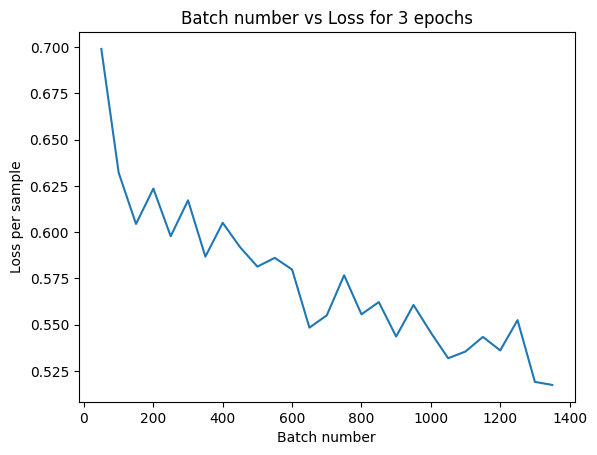

In [49]:
num_losses = len(batch_losses3)
x = [(i + 1)*50 for i in range(num_losses)]
plt.plot(x, batch_losses3)
plt.title("Batch number vs Loss for 3 epochs")
plt.xlabel("Batch number")
plt.ylabel("Loss per sample")

Text(0, 0.5, 'Loss per sample')

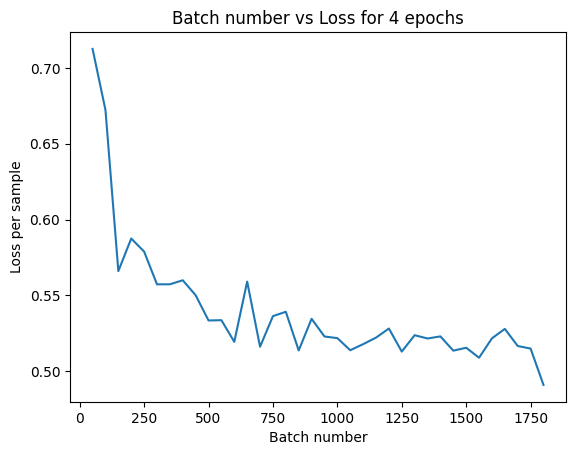

In [50]:
num_losses = len(batch_losses4)
x = [(i + 1)*50 for i in range(num_losses)]
plt.plot(x, batch_losses4)
plt.title("Batch number vs Loss for 4 epochs")
plt.xlabel("Batch number")
plt.ylabel("Loss per sample")

Text(0, 0.5, 'Loss per sample')

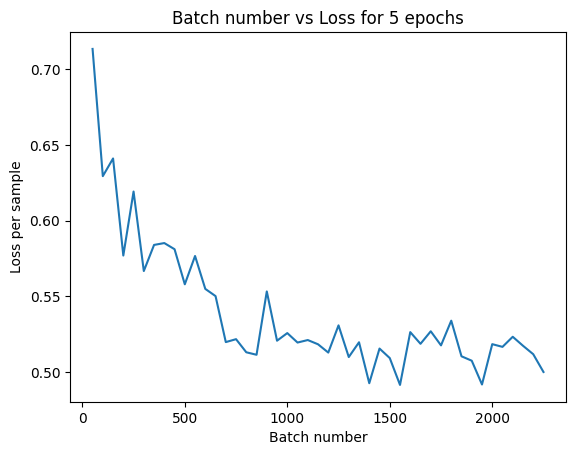

In [51]:
num_losses = len(batch_losses5)
x = [(i + 1)*50 for i in range(num_losses)]
plt.plot(x, batch_losses5)
plt.title("Batch number vs Loss for 5 epochs")
plt.xlabel("Batch number")
plt.ylabel("Loss per sample")

<h2>Evaluate R^2 of model against validation set<h2>

In [30]:
mean = pd.Series(labeled_dataset.output_traits_mean.values)
std = pd.Series(labeled_dataset.output_traits_std.values)

def eval_r_squared(model, modelId):
    with torch.no_grad():
        for i, sample_batch in enumerate(val_dataloader, 0):
            image_batch = sample_batch["image"][0].to(device)
            ancillary_batch = sample_batch["norm_input_traits"].to(device)
            true_labels = sample_batch["output_traits"]
            ids_tensor = sample_batch["id"].cpu()
            len_ids = len(ids_tensor)
            ids = pd.DataFrame(torch.reshape(ids_tensor, (len_ids, 1)))
            prediction = model(image_batch, ancillary_batch).cpu()
            df = pd.DataFrame(prediction.numpy())
            unnormalized_prediction = unnormalize(df, mean, std)

            df_true_labels = pd.DataFrame(true_labels.numpy())

            unnormalized_prediction.to_csv(f'val_predictions{modelId}.csv', mode='a', index=False, header=False)
            df_true_labels.to_csv(f'val_true_labels{modelId}.csv', mode='a', index=False, header=False)

In [ ]:
# Eval myNet3
eval_r_squared(myNet3, modelId=3)
predicted_csv_myNet3 = pd.read_csv("/kaggle/working/val_predictions3.csv", header=0)
true_csv_myNet3 = pd.read_csv("/kaggle/working/val_true_labels3.csv", header=0)
r2_score_myNet3 = r2_score(true_csv_myNet3, predicted_csv_myNet3, sample_weight=None, multioutput=None)

In [34]:
r2_score_myNet3

0.17966848415680378

In [31]:
# Eval myNet4
eval_r_squared(myNet4, modelId=4)
predicted_csv_myNet4 = pd.read_csv("/kaggle/working/val_predictions4.csv", header=0)
true_csv_myNet4 = pd.read_csv("/kaggle/working/val_true_labels4.csv", header=0)
r2_score_myNet4 = r2_score(true_csv_myNet4, predicted_csv_myNet4, sample_weight=None, multioutput=None)

In [35]:
r2_score_myNet4

0.20556482179193028

In [36]:
# Eval myNet5
eval_r_squared(myNet5, modelId=5)
predicted_csv_myNet5 = pd.read_csv("/kaggle/working/val_predictions5.csv", header=0)
true_csv_myNet5 = pd.read_csv("/kaggle/working/val_true_labels5.csv", header=0)
r2_score_myNet5 = r2_score(true_csv_myNet5, predicted_csv_myNet5, sample_weight=None, multioutput=None)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [37]:
r2_score_myNet5

0.21299750131481562

<BarContainer object of 3 artists>

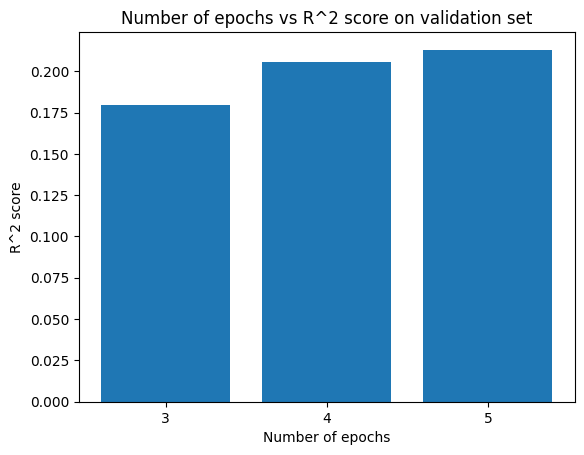

In [58]:
r2_scores = [r2_score_myNet3, r2_score_myNet4, r2_score_myNet5]
x = [3, 4, 5]
plt.title("Number of epochs vs R^2 score on validation set")
plt.ylabel("R^2 score")
plt.xlabel("Number of epochs")
plt.xticks(np.arange(3, 6, 1.0))
plt.bar(x, r2_scores)

<h2>Define three more regression models to be used in the final ensemble<h2>

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import normalize

def loadCsvData(csv_file):
    return pd.read_csv(ROOT_DIR + f"/data/{csv_file}", header=0)

train_vals = loadCsvData("train.csv")
COLUMN_NAMES = list(train_vals.columns)
ALL_INPUT_TRAITS = COLUMN_NAMES[1:-6]
INPUT_TRAIT_NAMES = ALL_INPUT_TRAITS

input_traits_train = train_vals[INPUT_TRAIT_NAMES]
output_traits_train = train_vals[OUTPUT_TRAIT_NAMES]

norm_input_traits_train = (input_traits_train-input_traits_train.mean())/input_traits_train.std()
norm_output_traits_train = (output_traits_train-output_traits_train.mean())/output_traits_train.std()

In [59]:
def getFittedModel(input_traits, output_traits, model):
    scores = cross_val_score(model, input_traits, output_traits, cv=5)
    print(scores)
    model.fit(input_traits, output_traits)
    return model, scores

model1, scores1 = getFittedModel(norm_input_traits_train, norm_output_traits_train, LinearRegression())
model2, scores2 = getFittedModel(norm_input_traits_train, norm_output_traits_train, KNeighborsRegressor(n_neighbors=10))
model3, scores3 = getFittedModel(norm_input_traits_train.iloc[:, :6], norm_output_traits_train, RandomForestRegressor(verbose=1))

[0.16626419 0.15951519 0.16397977 0.16191402 0.16079204]
[0.16305706 0.15421981 0.16143861 0.16108168 0.15522039]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[0.14889846 0.14199186 0.14081769 0.13064541 0.13606785]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.0s


<h2>Define R^2 evaluation function for the complete ensemble model (StackedNN + the 3 other regression models)</h2>

<h3>Evaluate on validation set again</h3>

In [64]:
mean = pd.Series(labeled_dataset.output_traits_mean.values)
std = pd.Series(labeled_dataset.output_traits_std.values)

def eval_r_squared_multiple(model1, model2, model3, model4):
    with torch.no_grad():
        for i, sample_batch in enumerate(val_dataloader, 0):
            image_batch = sample_batch["image"][0].to(device)
            ancillary_batch = sample_batch["norm_input_traits"].to(device)
            true_labels = sample_batch["output_traits"]
            ids_tensor = sample_batch["id"].cpu()
            len_ids = len(ids_tensor)
            ids = pd.DataFrame(torch.reshape(ids_tensor, (len_ids, 1)))
            prediction1 = model1(image_batch, ancillary_batch).cpu()
            prediction_df1 = pd.DataFrame(prediction1.numpy())
            unnormalized_prediction1 = unnormalize(prediction_df1, mean, std)
            
            ancillary_df = pd.DataFrame(sample_batch["norm_input_traits"].cpu().numpy())
            
            prediction_df2 = pd.DataFrame(model2.predict(ancillary_df))
            unnormalized_prediction2 = unnormalize(prediction_df2, mean, std)
            prediction_df3 = pd.DataFrame(model3.predict(ancillary_df))
            unnormalized_prediction3 = unnormalize(prediction_df3, mean, std)
            prediction_df4 = pd.DataFrame(model4.predict(ancillary_df.iloc[:, :6]))
            unnormalized_prediction4 = unnormalize(prediction_df4, mean, std)
        
            ## Take weighted average of 4 model predictions
            final_prediction = 0.4 * unnormalized_prediction1 + 0.22 * unnormalized_prediction2 + 0.22 * unnormalized_prediction3 + 0.16 * unnormalized_prediction4

            true_labels = pd.DataFrame(true_labels.numpy())

            final_prediction.to_csv(f'validation_prediction.csv', mode='a', index=False, header=False)
            true_labels.to_csv(f'validation_true_outputs.csv', mode='a', index=False, header=False)

In [ ]:
eval_r_squared_multiple(myNet5, model1, model2, model3)

In [66]:
predicted_csv_val = pd.read_csv("/kaggle/working/validation_prediction.csv", header=0)
true_csv_val = pd.read_csv("/kaggle/working/validation_true_outputs.csv", header=0)
r2_score(true_csv_val, predicted_csv_val, sample_weight=None, multioutput=None)

0.3841468987975604

<h2>Output final predictions!</h2>

In [61]:
mean = pd.Series(labeled_dataset.output_traits_mean.values)
std = pd.Series(labeled_dataset.output_traits_std.values)

def test_multiple(model1, model2, model3, model4):
    with torch.no_grad():
        for i, sample_batch in enumerate(test_dataloader, 0):
            image_batch = sample_batch["image"][0].to(device)
            ancillary_batch = sample_batch["norm_input_traits"].to(device)
            ids_tensor = sample_batch["id"].cpu()
            len_ids = len(ids_tensor)
            ids = pd.DataFrame(torch.reshape(ids_tensor, (len_ids, 1)))
            prediction1 = model1(image_batch, ancillary_batch).cpu()
            prediction_df1 = pd.DataFrame(prediction1.numpy())
            unnormalized_prediction1 = unnormalize(prediction_df1, mean, std)
            
            ancillary_df = pd.DataFrame(sample_batch["norm_input_traits"].cpu().numpy())
            
            prediction_df2 = pd.DataFrame(model2.predict(ancillary_df))
            unnormalized_prediction2 = unnormalize(prediction_df2, mean, std)
            prediction_df3 = pd.DataFrame(model3.predict(ancillary_df))
            unnormalized_prediction3 = unnormalize(prediction_df3, mean, std)
            prediction_df4 = pd.DataFrame(model4.predict(ancillary_df.iloc[:, :6]))
            unnormalized_prediction4 = unnormalize(prediction_df4, mean, std)
            
            ## Take weighted average of 4 model predictions
            final_prediction = 0.4 * unnormalized_prediction1 + 0.22 * unnormalized_prediction2 + 0.22 * unnormalized_prediction3 + 0.16 * unnormalized_prediction4
            output = pd.concat([ids, final_prediction], axis=1)

            output.to_csv('my_prediction6.csv', mode='a', index=False, header=False)



In [ ]:
test_multiple(myNet5, model1, model2, model3)